<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
train_data = datasets.CIFAR10(
    train=True,
    root="data",
    transform=ToTensor(),
    download=True,
    target_transform=None
)
test_data = datasets.CIFAR10(
    train=False,
    root="data",
    transform=ToTensor(),
    download = True,
    target_transform=None
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12882577.98it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
classes = train_data.classes
labels = train_data.targets

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

torch.Size([3, 32, 32]) 9


Text(0.5, 1.0, 'truck')

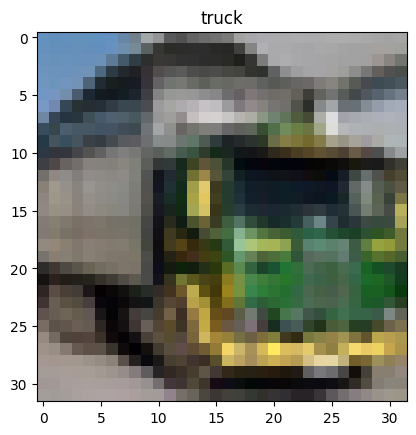

In [5]:
n = 14
image, label = train_data[n]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[labels[n]])

In [40]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("hepler_functions.py", "wb") as f:
        f.write(request.content)
from hepler_functions import accuracy_fn

In [56]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """
    Функция для отслеживания времени работы модели НН
    """
    total_time = end - start
    print(f"Total time on {device}: {total_time:.3f} seconds.")
    return total_time

In [57]:
"""def accuracy_fn(y_preds: torch.Tensor,
                y_true: torch.Tensor)->torch.float:
                correct = torch.eq(y_preds, y_true).sum().item()
                acc = (correct / len(y_preds))*100
                return acc"""
                

'def accuracy_fn(y_preds: torch.Tensor,\n                y_true: torch.Tensor)->torch.float:\n                correct = torch.eq(y_preds, y_true).sum().item()\n                acc = (correct / len(y_preds))*100\n                return acc'

In [58]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model.forward(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Batch {batch}: {batch* len(X)}/{len(data_loader.dataset)} samples.")
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [59]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            test_pred = model.forward(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [60]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    """
    Функция для оценки модели
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X = X.to(device)
            y = y.to(device)
            y_logits = model.forward(X)
            y_preds = torch.argmax(y_logits, dim=1)
            loss += loss_fn(y_logits, y)
            acc += accuracy_fn(y_pred=y_preds,
                               y_true=y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

## Model_2

In [61]:
class ModelV2(nn.Module):
    """
    Модель основана на архитектуре TinyVGG
    """
    def __init__(self, 
                 input_shape,
                 hidden_units,
                 output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 8 * 8,
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier: {x.shape}")
        return x

In [54]:
model_2 = ModelV2(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [55]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0: 0/50000samples.
Batch 400: 12800/50000samples.
Batch 800: 25600/50000samples.
Batch 1200: 38400/50000samples.
Train loss:1.83186|Train acc:34.23%
Test loss:1.59605|Test acc:44.06%

Epoch: 1
----------------------
Batch 0: 0/50000samples.
Batch 400: 12800/50000samples.
Batch 800: 25600/50000samples.
Batch 1200: 38400/50000samples.
Train loss:1.39166|Train acc:50.75%
Test loss:1.36085|Test acc:51.32%

Epoch: 2
----------------------
Batch 0: 0/50000samples.
Batch 400: 12800/50000samples.
Batch 800: 25600/50000samples.
Batch 1200: 38400/50000samples.
Train loss:1.25935|Train acc:55.74%
Test loss:1.42112|Test acc:51.60%

Epoch: 3
----------------------
Batch 0: 0/50000samples.
Batch 400: 12800/50000samples.
Batch 800: 25600/50000samples.
Batch 1200: 38400/50000samples.
Train loss:1.20880|Train acc:57.64%
Test loss:1.18590|Test acc:58.15%

Epoch: 4
----------------------
Batch 0: 0/50000samples.
Batch 400: 12800/50000samples.
Batch 800: 25600/50000sa